In [1]:
import matplotlib.pyplot as plt
import numpy as np
import camb

In [2]:
h = 0.6756
omegabh2 = 0.022
omegach2 = 0.12
As = 2.215e-9
ns = 0.962

cases = [8, 10, 15, "LCDM"]
results = []
for case in cases:
	if case == "LCDM":
		cosmo = camb.set_params(# Background
			H0=100*h, ombh2=omegabh2, omch2=omegach2, TCMB=2.7255,
			# Dark Energy
			dark_energy_model='HybridQuintessence', phi_i=100,
			# Neutrinos
			omnuh2=0, num_nu_massless=3.044, num_nu_massive = 0,
			nu_mass_degeneracies=[0], nu_mass_numbers = [0],
			# Initial Power Spectrum
			As=As, ns=ns, 
			YHe = 0.246, WantTransfer=True
		)
	else:
		cosmo = camb.set_params(# Background
			H0=100*h, ombh2=omegabh2, omch2=omegach2, TCMB=2.7255,
			# Dark Energy
			dark_energy_model = 'HybridQuintessence', phi_i=case,
			# Neutrinos
			omnuh2=0, num_nu_massless=3.044, num_nu_massive = 0,
			nu_mass_degeneracies=[0], nu_mass_numbers = [0],
			# Initial Power Spectrum
			As = 2.100549e-09, ns = 0.9660499, 
			YHe = 0.246, WantTransfer=True
		)
	results.append(camb.get_results(cosmo))

 Shooting for V0 with tentative values:    5.2471497518475369E-008   1.3642589354803597E-007 using phi_i =    8.0000000000000000     
 Target Omega_de:  0.68880188030430434      Target omega_cdm:  0.26290688784497329     
 V0 =    5.2471497518475369E-008 => omega_de =   0.34639558715560348     
 V0 =    1.3642589354803597E-007 => omega_de =   0.89694185779238722     
 V0 =    1.0468602529062884E-007 => omega_de =   0.68943402284279542      (error =    9.1774217894384134E-004 ), omega_cdm =   0.25902497591641716      (error =   -1.4765348904990119E-002 )
 V0 =    1.0458980568169237E-007 => omega_de =   0.68885358012940145      (error =    7.5057613191005726E-005 ), omega_cdm =   0.26258149330144948      (error =   -1.2376797967944048E-003 )
 V0 =    1.0458193754174038E-007 => omega_de =   0.68880623677669750      (error =    6.3247103669906401E-006 ), omega_cdm =   0.26287979429745234      (error =   -1.0305377597002001E-004 )
 V0 =    1.0458127454339729E-007 => omega_de =   0.688802243

In [3]:
species = ["K", "cdm", "baryon", "photon", "neutrino", "de"]
scale_factor = np.linspace(1e-3, 1, 1000)
for i in range(4):
    rhos = results[i].get_background_densities(scale_factor)
    rhotot = sum([rhos[s][-1] for s in species])
    print(rhotot, rhos['tot'][-1])
    print(rhos['cdm'][-1]/rhos['tot'][-1])
    print('--')

1.5235582468072585e-07 1.5235582468072585e-07
0.26290674158728927
--
1.5235583734739453e-07 1.5235583734739453e-07
0.2629068196262464
--
1.523558479804163e-07 1.523558479804163e-07
0.26290688374459253
--
1.5235584888444467e-07 1.5235584888444467e-07
0.2629068891412189
--


Text(0, 0.5, '$\\Omega$')

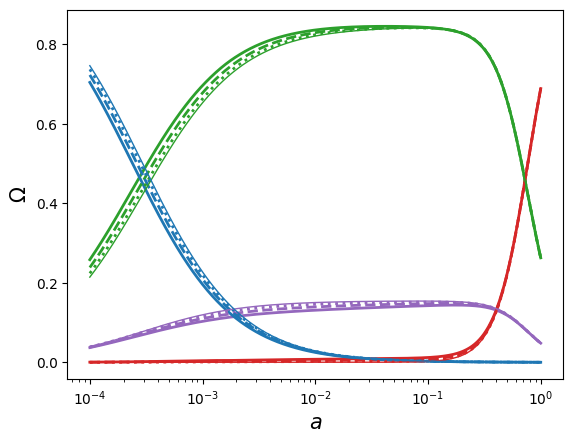

In [4]:
# fig, axs = plt.subplots(2, 1, figsize=(10,10))
scale_factor = np.logspace(-4, 0, 10000)
redshift = 1/scale_factor - 1
lws = [2, 2, 2, 1]
lss = ['-', '--', ':', '-']
colors = ['tab:red', 'tab:green', 'tab:purple', 'black']
legend_labels = [fr"$\phi_i = {case}$" if case != "LCDM" else fr"$\Lambda CDM$" for case in cases]
for case, result, ls, lw, color, label in zip(cases, results, lss, lws, colors, legend_labels):
    # rho_de, w_de = result.get_dark_energy_rho_w(scale_factor)
    rhos = result.get_background_densities(scale_factor)
    plt.semilogx(scale_factor, rhos['de']/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:red')
    plt.semilogx(scale_factor, rhos['cdm']/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:green')
    plt.semilogx(scale_factor, rhos['baryon']/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:purple')
    plt.semilogx(scale_factor, (rhos['photon'] + rhos['neutrino'])/rhos['tot'], ls=ls, lw=lw, label=label, color='tab:blue')

plt.xlabel(r"$a$", fontsize=15)
plt.ylabel(r"$\Omega$", fontsize=15)

Text(0, 0.5, '$P(k, z=0)$')

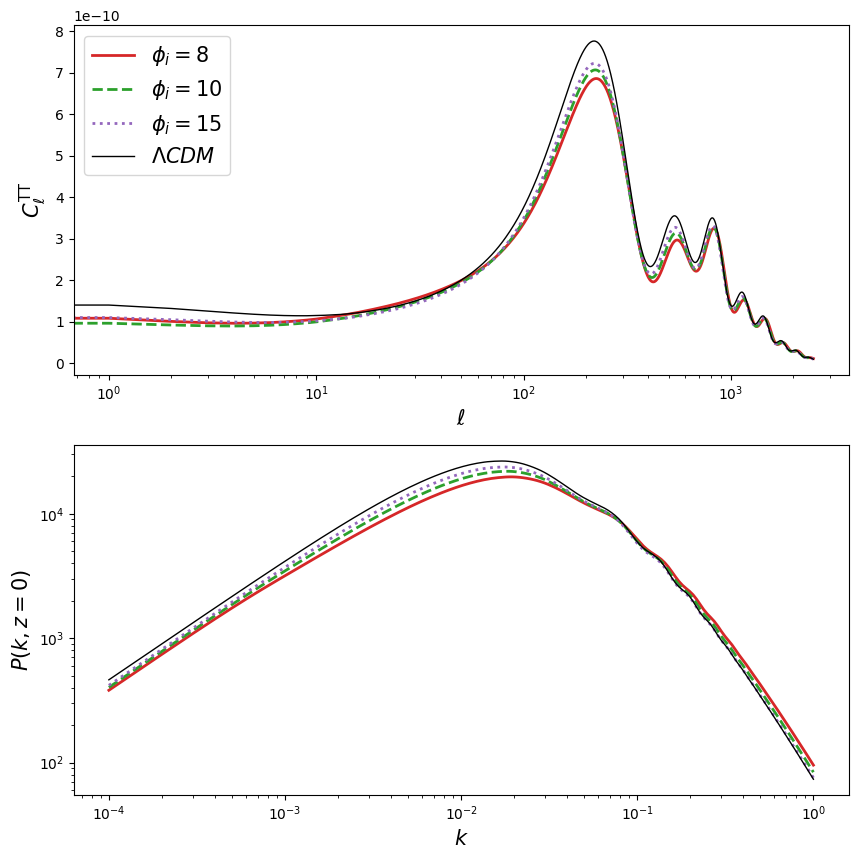

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
scale_factor = np.logspace(-4, 0, 10000)
redshift = 1/scale_factor - 1
lws = [2, 2, 2, 1]
lss = ['-', '--', ':', '-']
colors = ['tab:red', 'tab:green', 'tab:purple', 'black']
legend_labels = [fr"$\phi_i = {case}$" if case != "LCDM" else fr"$\Lambda CDM$" for case in cases]
for case, result, ls, lw, color, label in zip(cases, results, lss, lws, colors, legend_labels):
    rho_de, w_de = result.get_dark_energy_rho_w(scale_factor)
    ks = result.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[0]
    pk = result.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)[2][0]
    c_ells = result.get_unlensed_scalar_cls()[:,0]
    axs[0].semilogx(c_ells[2:], ls=ls, lw=lw, label=label, color=color)
    axs[1].loglog(ks, pk, ls=ls, lw=lw, label=label, color=color)
    
axs[0].legend(loc='upper left', fontsize=15)
axs[0].set_xlabel(r"$\ell$", fontsize=15)
axs[0].set_ylabel(r"$C_\ell^\mathrm{TT}$", fontsize=15)
axs[1].set_xlabel(r"$k$", fontsize=15)
axs[1].set_ylabel(r"$P(k, z=0)$", fontsize=15)